### Libraries

In [1]:
import cv2
import numpy as np
import tifffile
import zarr
import matplotlib.pyplot as plt
import json

### Functions

In [233]:
def find_rect(image):
    """
    This function takes an image (numpy array), detects light rectangular contours, and draws them on the image.

    Parameters:
    image_np (numpy array): The input image in which to detect and draw rectangles.

    Returns:
    tuple: A tuple containing:
           - list of numpy arrays: The list of detected rectangles (each represented by its vertices).
           - numpy array: The image with detected rectangles drawn on it.
    """
    image_np = np.array(image)
    # Copy the input image to avoid modifying the original one
    image = image_np.copy()

    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Apply thresholding to the blurred image to create a binary image
    _, thresh = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Initialize a list to hold detected rectangles
    vertices = []
    areas = []

    # Iterate over each contour
    for contour in contours:
        # Approximate the contour to a polygon
        approx = cv2.approxPolyDP(contour, 0.02 * cv2.arcLength(contour, True), True)
        area = cv2.contourArea(approx)
        # If the polygon has 4 vertices, it is considered a rectangle
        if len(approx) == 4 and area > 1000:
            vertices.append(approx)
            areas.append(area)

    # Draw the detected rectangles on the image
    for rect in vertices:
        cv2.drawContours(image, [rect], -1, (0, 255, 0), 20)

    vertices_upd = [
        (
            vert[:, 0, 1].min(),
            vert[:, 0, 1].max(),
            vert[:, 0, 0].min(),
            vert[:, 0, 0].max(),
        )
        for vert in vertices
    ]

    combined = list(zip(areas, vertices_upd))
    combined.sort(key=lambda x: x[0], reverse=True)

    rect_dict = {}
    keys = ["CA", "rect_1000", "rect_750", "rect_500", "rect_400", "rect_300"]
    for i, key in enumerate(keys):
        area, (y0, y1, x0, x1) = combined[i]
        rect_dict[key] = {"y0": y0, "y1": y1, "x0": x0, "x1": x1}

    return rect_dict, areas, image

In [4]:
def convert_numpy_types(obj):
    if isinstance(obj, np.integer):
        return int(obj)
    if isinstance(obj, np.floating):
        return float(obj)
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

In [5]:
def compute_sobel_magnitude(image_np):
    """
    Computes the Sobel magnitude of the input image.

    Parameters:
    image_np (numpy array): The input image.

    Returns:
    numpy array: The Sobel magnitude image.
    """
    # Apply Sobel operator to find the gradient in the x direction
    sobelx = cv2.Sobel(image_np, cv2.CV_64F, 1, 0, ksize=3)

    # Apply Sobel operator to find the gradient in the y direction
    sobely = cv2.Sobel(image_np, cv2.CV_64F, 0, 1, ksize=3)

    # Compute the magnitude of the gradient
    sobel_magnitude = np.sqrt(sobelx**2 + sobely**2)

    # Convert the magnitude to 8-bit image
    sobel_magnitude = cv2.convertScaleAbs(sobel_magnitude)

    return sobel_magnitude

In [6]:
def enhance_contrast(image_np):
    """
    Enhances the contrast of the image using CLAHE.

    Steps:
    1. Convert the input image from the BGR color space to the LAB color space using `cv2.cvtColor`.
    2. Split the LAB image into its three channels: L, A, and B using `cv2.split`.
    3. Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to the L channel to enhance the contrast.
       CLAHE works by limiting the contrast amplification to prevent noise amplification, which is done using the `clipLimit` and `tileGridSize` parameters.
    4. Merge the enhanced L channel back with the A and B channels using `cv2.merge`.
    5. Convert the LAB image back to the BGR color space using `cv2.cvtColor`.

    Parameters:
    image_np (numpy array): The input image.

    Returns:
    numpy array: The image with enhanced contrast.
    """
    # Convert the image to the LAB color space
    lab = cv2.cvtColor(image_np, cv2.COLOR_BGR2LAB)

    # Split the LAB image into its channels
    l, a, b = cv2.split(lab)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    # Merge the CLAHE enhanced L channel back with the A and B channels
    limg = cv2.merge((cl, a, b))

    # Convert the LAB image back to the BGR color space
    enhanced_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
    return enhanced_image

In [235]:
def find_circles(
    input_image, dp=1.2, minDist=50, param1=50, param2=30, minRadius=0, maxRadius=0
):
    """
    This function takes an image (numpy array) and detects circles using the HoughCircles method.

    Parameters:
    input_image (numpy array): The input image in which to detect circles.
    dp (float): The inverse ratio of the accumulator resolution to the image resolution. Default is 1.2.
    minDist (int): Minimum distance between the centers of the detected circles. Default is 50.
    param1 (int): Gradient value used to handle edge detection in the Canny method. Default is 50.
    param2 (int): Accumulator threshold for the circle centers at the detection stage. Default is 30.
    minRadius (int): Minimum circle radius. Default is 0.
    maxRadius (int): Maximum circle radius. Default is 0.

    Returns:
    tuple: A tuple containing:
           - list of numpy arrays: The list of detected circles (each represented by its center coordinates and radius).
           - numpy array: The image with detected circles drawn on it.
    """
    # Copy the input image to avoid modifying the original one
    image_copy = input_image.copy()

    # Convert the image to grayscale
    gray = cv2.cvtColor(image_copy, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (7, 7), 2)

    # Detect circles in the image using HoughCircles
    circles = cv2.HoughCircles(
        blurred,
        cv2.HOUGH_GRADIENT,
        dp,
        minDist,
        param1=param1,
        param2=param2,
        minRadius=minRadius,
        maxRadius=maxRadius,
    )

    # If some circles are detected, process them
    if circles is not None:
        circles = np.uint16(
            np.around(circles)
        )  # Round the values and convert to unsigned 16-bit integers
        for circle in circles[0, :]:
            center = (circle[0], circle[1])  # Center coordinates of the circle
            radius = circle[2]  # Radius of the circle
            # Draw the circle's center
            cv2.circle(image_copy, center, 1, (0, 100, 100), 3)
            # Draw the circle's outline
            cv2.circle(image_copy, center, radius, (255, 0, 255), 3)

    return circles, image_copy

In [ ]:
def group_and_average(coordinates, threshold=10):
    def distance(coord1, coord2):
        return np.linalg.norm(np.array(coord1) - np.array(coord2))

    unique_groups = []
    for coord in coordinates:
        placed = False
        for group in unique_groups:
            if all(distance(coord, member) <= threshold for member in group):
                group.append(coord)
                placed = True
                break
        if not placed:
            unique_groups.append([coord])

    mean_values = [
        np.mean(group, axis=0).astype(int).tolist() for group in unique_groups
    ]
    return mean_values

In [236]:
def find_circ(image, width):

    def is_circle(contour, tolerance=0.2):
        perimeter = cv2.arcLength(contour, True)
        area = cv2.contourArea(contour)
        if perimeter < int(width / 6):
            return False
        circularity = 4 * np.pi * (area / (perimeter * perimeter))
        return 1 - tolerance <= circularity <= 1 + tolerance

    sobel = compute_sobel_magnitude(image)
    enhanced = enhance_contrast(enhance_contrast(sobel))

    # Convert the image to grayscale
    gray = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image to reduce noise
    blurred = cv2.GaussianBlur(gray, (9, 9), 0)

    # Using Canny for edge detection
    edges = cv2.Canny(blurred, 50, 150)

    # Find contours
    contours, _ = cv2.findContours(edges, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Filter contours to keep only circles
    circles = [contour for contour in contours if is_circle(contour)]

    circles_coord = []
    for contour in circles:
        (x, y), radius = cv2.minEnclosingCircle(contour)
        center = (int(x), int(y))
        radius = int(radius)
        circles_coord.append([center[0], center[1], radius])

    mean_radius = int(np.mean([c[2] for c in circles_coord]))

    image_copy = image.copy()

    for contour in circles_coord:
        x, y, radius = contour[0], contour[1], mean_radius
        center = (int(x), int(y))
        cv2.circle(image_copy, center, radius, (0, 255, 0), 2)

    circles_coord = group_and_average(circles_coord, threshold=10)

    for contour in circles_coord:
        contour[2] = mean_radius

    return circles_coord, image_copy

In [237]:
def circ_to_dict(circles_coord, size):
    # Sort by y-coordinate
    sorted_by_y = sorted(circles_coord, key=lambda item: item[1])

    # Sort each subgroup of 4 by x-coordinate
    n = 4
    for i in range(0, len(sorted_by_y), n):
        subgroup = sorted_by_y[i : i + n]
        sorted_subgroup = sorted(subgroup, key=lambda item: item[0])
        sorted_by_y[i : i + n] = sorted_subgroup

    # Characters and numbers for generating keys
    characters = ["A", "B", "C", "D"]
    numbers = [6, 5, 4, 3, 2, 1]

    # Dictionary to hold the result
    result_dict = {}
    index = 0

    # Generate keys and fill the dictionary
    for num in numbers:
        for char in characters:
            if index < len(sorted_by_y):
                key = f"{char}{num}{size}"
                x, y, radius = sorted_by_y[index]
                result_dict[key] = {"x_centroid": x, "y_centroid": y, "radius": radius}
                index += 1

    return result_dict

### 1. Download

In [227]:
filename = "IHCjul23_020723.ome.tiff"
tiff_storage = tifffile.imread(
    "/Users/lune/Education/Color/Palettes/IHCjul23_020723.ome.tiff", aszarr=True
)
zarr_storage = zarr.open(tiff_storage, mode="r")
zarr_small = zarr_storage[len(zarr_storage) - 2]

### 2. Rectangles

In [228]:
rect_dict, rect_areas, rect_image = find_rect(zarr_small)

In [229]:
rect_dict

{'CA': {'y0': 2417, 'y1': 3013, 'x0': 251, 'x1': 2528},
 'rect_1000': {'y0': 4250, 'y1': 5472, 'x0': 1738, 'x1': 2424},
 'rect_750': {'y0': 4556, 'y1': 5473, 'x0': 956, 'x1': 1469},
 'rect_500': {'y0': 4865, 'y1': 5476, 'x0': 356, 'x1': 698},
 'rect_400': {'y0': 3581, 'y1': 4069, 'x0': 316, 'x1': 589},
 'rect_300': {'y0': 3591, 'y1': 3954, 'x0': 950, 'x1': 1151}}

In [230]:
rect_areas

[206289.0, 464327.0, 830221.0, 72781.5, 131710.0, 1338586.0]

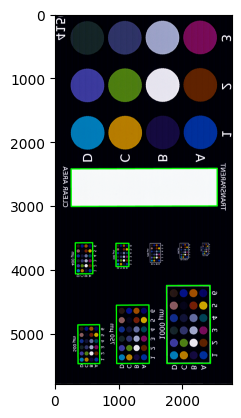

In [231]:
plt.imshow(rect_image)

### 2. Circles

In [249]:
rect_name = "rect_1000"

coords = rect_dict[rect_name]
zarr_small_crop = np.array(zarr_small)[
    coords["y0"] : coords["y1"], coords["x0"] : coords["x1"]
]
zarr_small_crop_width = coords["x1"] - coords["x0"]

circ_coord, _ = find_circ(zarr_small_crop, zarr_small_crop_width)
circ_dict = circ_to_dict(circ_coord, size=rect_name[4:])
for key, value in circ_dict.items():
    if "x_centroid" in value:
        value["x_centroid"] += coords["x0"]
        value["y_centroid"] += coords["y0"]

In [250]:
circ_dict

{'A6_1000': {'x_centroid': 1850, 'y_centroid': 4372, 'radius': 64},
 'B6_1000': {'x_centroid': 2004, 'y_centroid': 4371, 'radius': 64},
 'C6_1000': {'x_centroid': 2156, 'y_centroid': 4371, 'radius': 64},
 'D6_1000': {'x_centroid': 2310, 'y_centroid': 4370, 'radius': 64},
 'A5_1000': {'x_centroid': 1851, 'y_centroid': 4566, 'radius': 64},
 'B5_1000': {'x_centroid': 2004, 'y_centroid': 4565, 'radius': 64},
 'C5_1000': {'x_centroid': 2157, 'y_centroid': 4565, 'radius': 64},
 'D5_1000': {'x_centroid': 2310, 'y_centroid': 4565, 'radius': 64},
 'A4_1000': {'x_centroid': 1852, 'y_centroid': 4761, 'radius': 64},
 'B4_1000': {'x_centroid': 2005, 'y_centroid': 4760, 'radius': 64},
 'C4_1000': {'x_centroid': 2158, 'y_centroid': 4760, 'radius': 64},
 'D4_1000': {'x_centroid': 2312, 'y_centroid': 4760, 'radius': 64},
 'A3_1000': {'x_centroid': 1852, 'y_centroid': 4956, 'radius': 64},
 'B3_1000': {'x_centroid': 2006, 'y_centroid': 4955, 'radius': 64},
 'C3_1000': {'x_centroid': 2159, 'y_centroid': 4

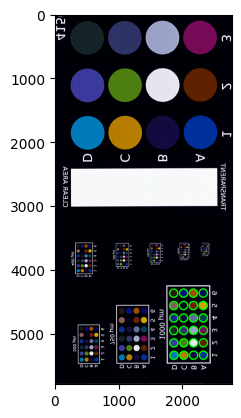

In [251]:
zarr_small_copy = np.array(zarr_small).copy()
for key, value in circ_dict.items():
    x, y, radius = value["x_centroid"], value["y_centroid"], value["radius"]
    center = (int(x), int(y))
    cv2.circle(zarr_small_copy, center, radius, (0, 255, 0), 20)
plt.imshow(zarr_small_copy)

### Output


In [ ]:
# Orientation
need_rotate = False
need_flip = False
if rect_dict["CA"]["y0"] > rect_dict["rect_1000"]["y0"]:
    need_rotate = True
if rect_dict["rect_1000"]["x0"] > rect_dict["rect_500"]["x0"]:
    need_flip = True

if need_rotate:
    zarr_small_crop = cv2.rotate(zarr_small_crop, cv2.ROTATE_180)
if need_flip:
    zarr_small_crop = cv2.flip(zarr_small_crop, 1)